# Import packages and data 

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import scipy.stats
import anndata
import matplotlib.pyplot as plt
import matplotlib as mpl

/Users/b8058304/.pyenv/versions/3.6.4/envs/py36/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [2]:
sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
# Set up the plot config for viewing the annotation clearly.
sc.settings.set_figure_params(dpi=120, dpi_save=1000)
sc.logging.print_versions()

scanpy==1.4.4 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.2 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [4]:
adata = sc.read('/Users/b8058304/Documents/PhD_work/Coding/ys/data/Liver_data_YS_paper_post_scrub.h5ad')

In [5]:
adata

AnnData object with n_obs × n_vars = 55790 × 25756 
    obs: 'n_genes', 'n_counts', 'orig_ident', 'percent_mito', 'fetal_ids', 'sort_ids', 'tissue', 'lanes', 'stages', 'sample_type', 'gender', 'AnnatomicalPart', 'fullmeta', 'scrublet_score', 'scrublet_cluster_score', 'bh_pval', 'short_code', 'oldanno', 'subcluster_annotation', 'pred', 'annotated_clusters', 'annotated_clusters_reduced'
    var: 'gene.mean', 'gene.dispersion', 'gene.dispersion.scaled'
    obsm: 'X_fdg', 'X_pca', 'X_tsne', 'X_umap'

# Have a look

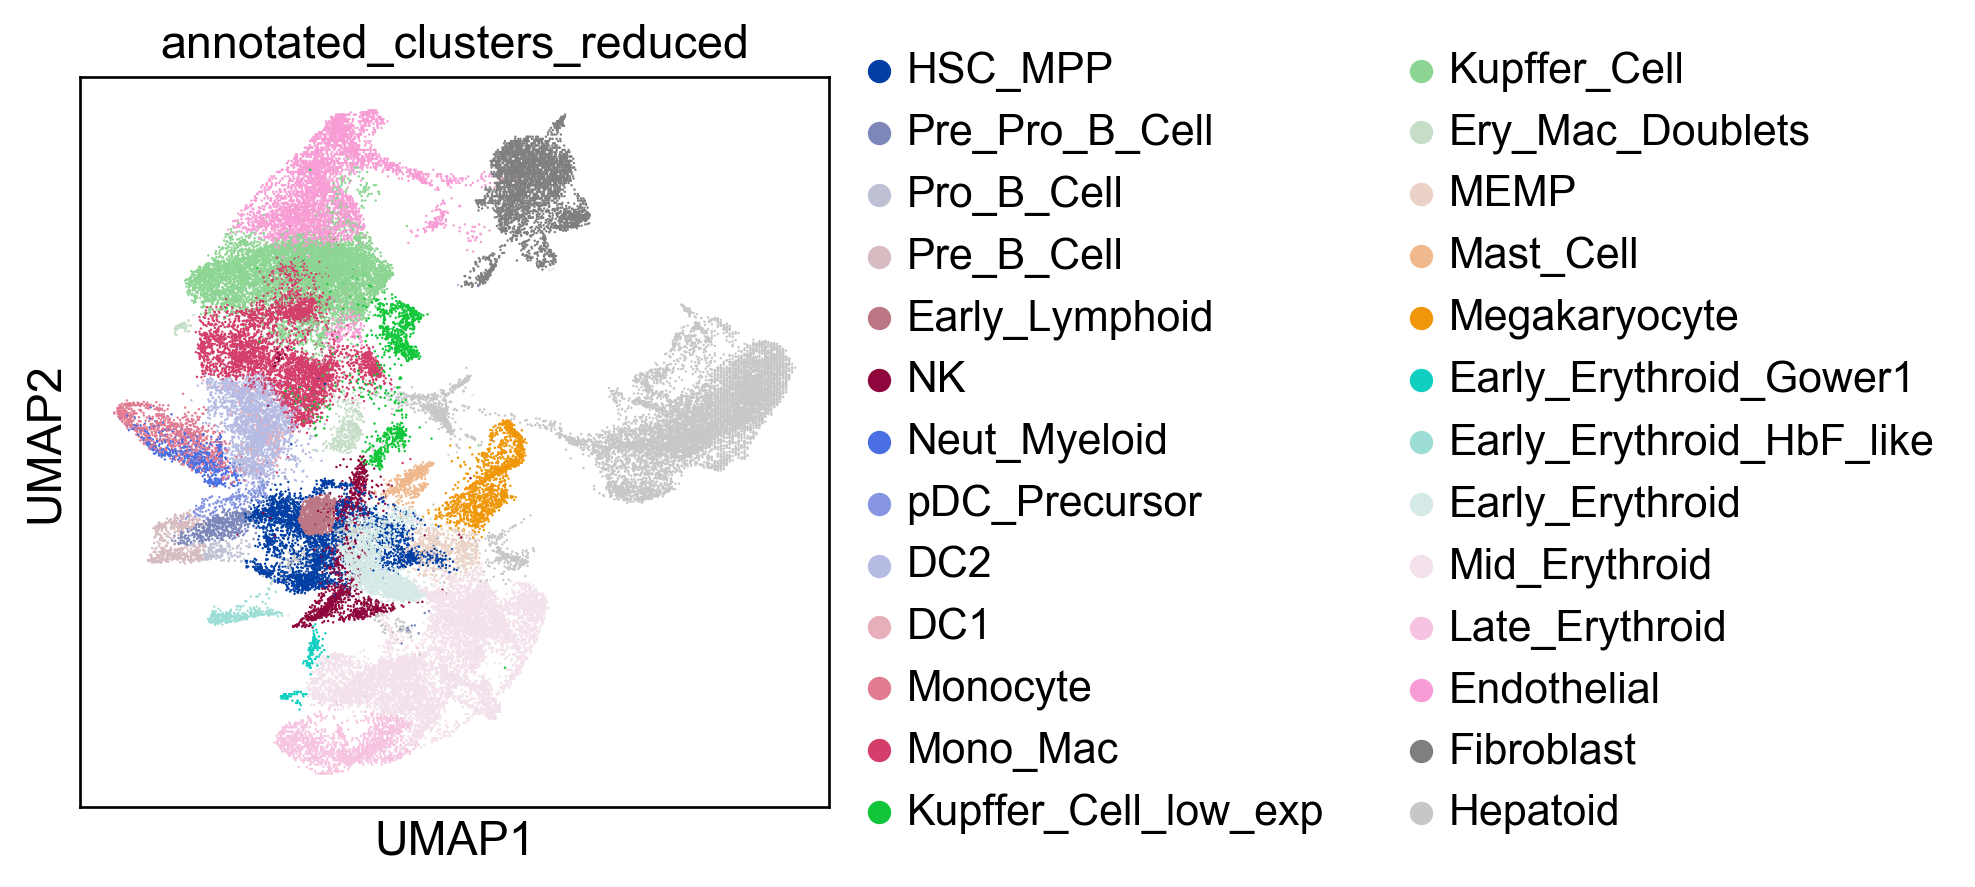

In [6]:
sc.pl.umap(adata, color=['annotated_clusters_reduced'])

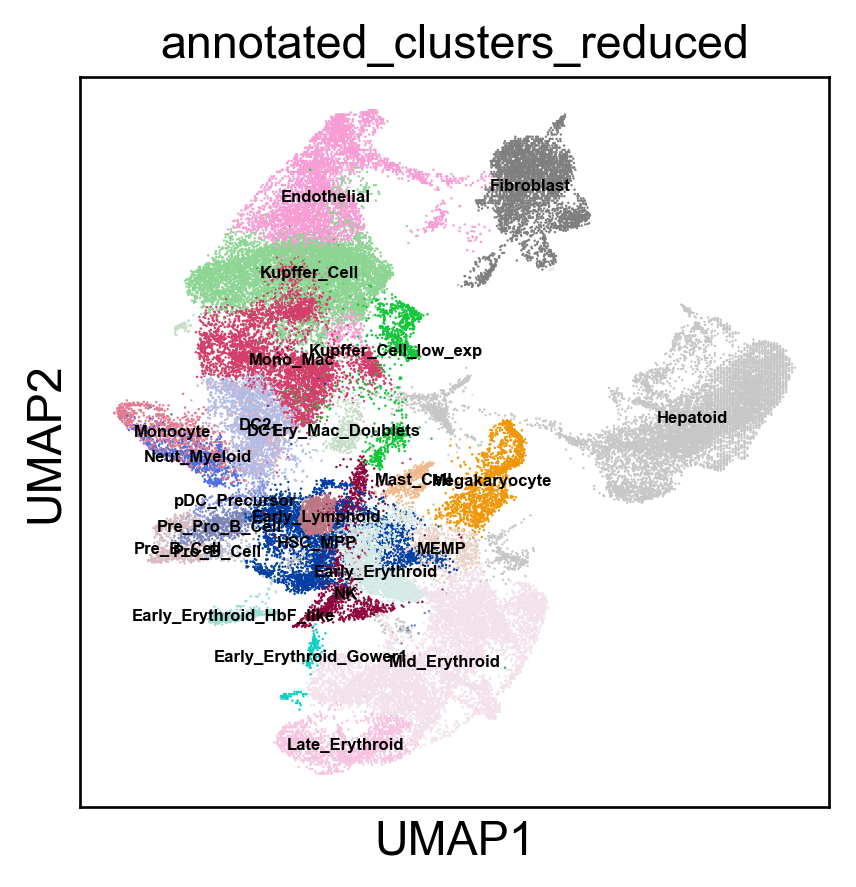

In [7]:
sc.pl.umap(adata, color=['annotated_clusters_reduced'], legend_loc="on data", legend_fontsize=5)

In [8]:
cell_numbers = adata.obs.groupby(["annotated_clusters_reduced"]).apply(len)
cell_numbers

annotated_clusters_reduced
HSC_MPP                      3090
Pre_Pro_B_Cell                522
Pro_B_Cell                    158
Pre_B_Cell                    530
Early_Lymphoid               1019
NK                           1213
Neut_Myeloid                  622
pDC_Precursor                 227
DC2                          2186
DC1                           217
Monocyte                      912
Mono_Mac                     4275
Kupffer_Cell_low_exp         1039
Kupffer_Cell                 7324
Ery_Mac_Doublets              420
MEMP                          596
Mast_Cell                     465
Megakaryocyte                1439
Early_Erythroid_Gower1        165
Early_Erythroid_HbF_like      328
Early_Erythroid              1954
Mid_Erythroid                7319
Late_Erythroid               1520
Endothelial                  4234
Fibroblast                   3841
Hepatoid                    10175
dtype: int64

# Remove low_exp and doublet populations

In [9]:
adata = adata[~adata.obs['annotated_clusters_reduced'].isin(['Kupffer_Cell_low_exp', 'Ery_Mac_Doublets'])].copy()

In [10]:
adata.shape

(54331, 25756)

In [11]:
cell_numbers = adata.obs.groupby(["annotated_clusters_reduced"]).apply(len)
cell_numbers

annotated_clusters_reduced
HSC_MPP                      3090
Pre_Pro_B_Cell                522
Pro_B_Cell                    158
Pre_B_Cell                    530
Early_Lymphoid               1019
NK                           1213
Neut_Myeloid                  622
pDC_Precursor                 227
DC2                          2186
DC1                           217
Monocyte                      912
Mono_Mac                     4275
Kupffer_Cell                 7324
MEMP                          596
Mast_Cell                     465
Megakaryocyte                1439
Early_Erythroid_Gower1        165
Early_Erythroid_HbF_like      328
Early_Erythroid              1954
Mid_Erythroid                7319
Late_Erythroid               1520
Endothelial                  4234
Fibroblast                   3841
Hepatoid                    10175
dtype: int64

# Subset out Myeloid,1, reannotate and save metadata as csv

In [54]:
unsure = adata[adata.obs['subcluster_annotation'].isin(['Myeloids,1'])].copy()

In [55]:
# normalise count data 
sc.pp.normalize_total(unsure)

In [56]:
# log the count data 
sc.pp.log1p(unsure)

In [57]:
# find variable genes
sc.pp.highly_variable_genes(unsure, min_mean=0.0125, max_mean=3, min_disp=0.5) 

In [58]:
# scale the data 
sc.pp.scale(unsure, max_value=10)
# scale the negative values in unsure.X (which have been normalised, logged and scaled) to zero 
unsure.X = np.where(unsure.X < 0, 0, unsure.X)

In [59]:
# run pca
sc.tl.pca(unsure, n_comps=50)

In [60]:
# run snn neighbourhood graph
sc.pp.neighbors(unsure, n_neighbors=40, n_pcs=10) 

In [61]:
# run umap
sc.tl.umap(unsure) 

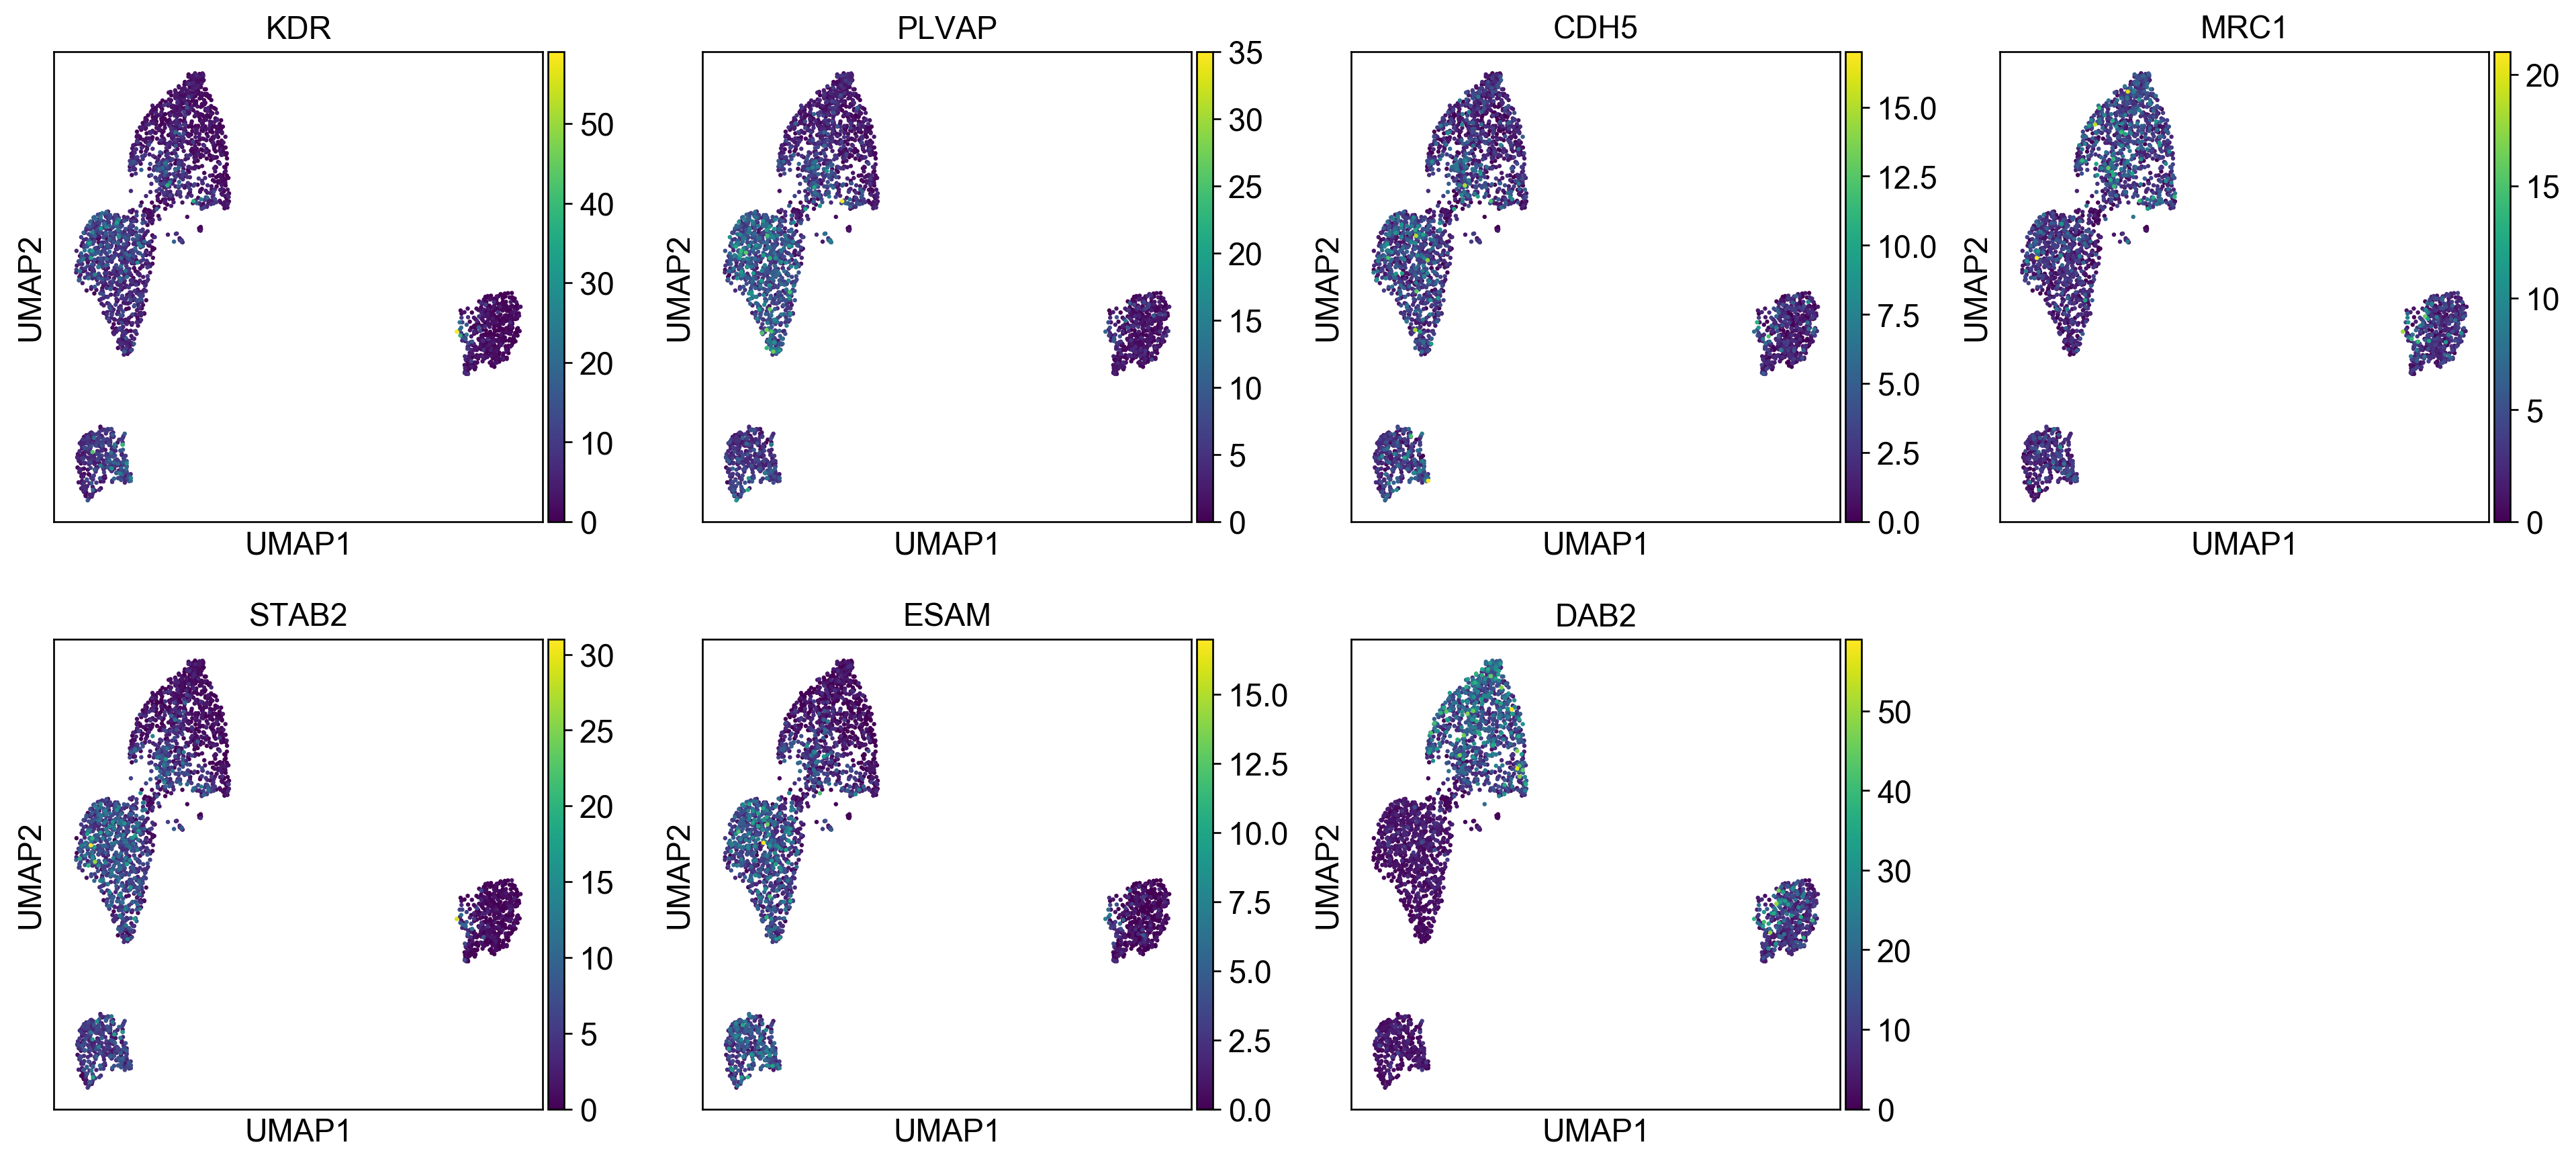

In [64]:
sc.pl.umap(unsure, color=['KDR', 'PLVAP', 'CDH5', 'MRC1', 'STAB2', 'ESAM', 'DAB2'], size=15) 

In [67]:
sc.tl.leiden(unsure, resolution=0.2, random_state=26, n_iterations=-1)

... storing 'subcluster_annotation' as categorical


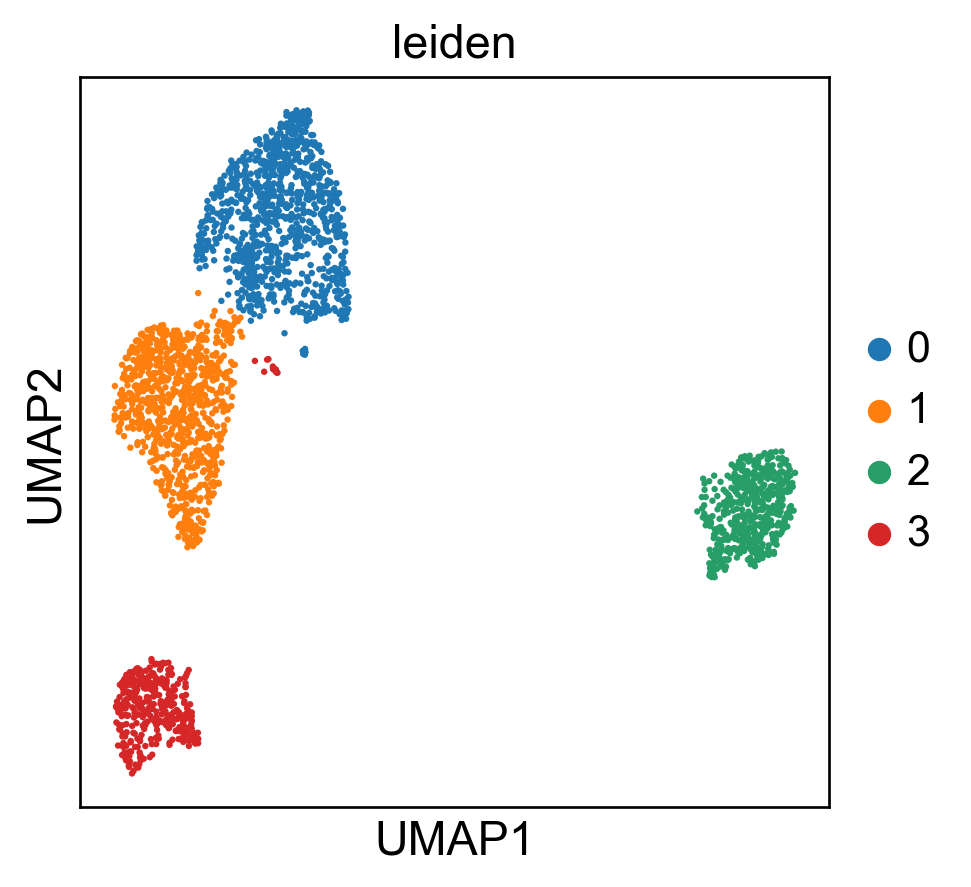

In [76]:
sc.pl.umap(unsure, color=['leiden'], size=15) 

In [77]:
unsure.obs["subcluster_annotation"] = unsure.obs["leiden"].replace(["0", "1", "2", "3"], ["Myeloid,1-1", "Myeloid,1-2", "Myeloid,1-3", "Myeloid,1-4"])

In [82]:
unsure.obs["subcluster_annotation"].to_csv('/Users/b8058304/Documents/PhD_work/Coding/ys/resources_for_pipelines/myeloid_subset_annots_20200422.csv')

# Add in updated annotations from Rachel (save as cell.labels)

In [25]:
cell_numbers = adata.obs.groupby(["subcluster_annotation"]).apply(len)
cell_numbers

subcluster_annotation
Endothelium          1156
Erythroid,0          2838
Erythroid,1          2653
Erythroid,10           54
Erythroid,2          1520
Erythroid,3          1008
Erythroid,4           594
Erythroid,6           328
Erythroid,7           226
Erythroid,8           194
Erythroid,9           111
Fibroblast,0         2047
Fibroblast,1          681
Fibroblast,2          516
Fibroblast,3          299
Fibroblast,4          188
Fibroblast,5          186
Fibroblast,6          112
Hepatoid,0           4154
Hepatoid,1           2648
Hepatoid,2            948
Hepatoid,3            608
Hepatoid,4            602
Hepatoid,5            549
Hepatoid,6            367
Hepatoid,7             50
Lymphoid_B_ILC,0      286
Lymphoid_B_ILC,1      252
Lymphoid_B_ILC,2      231
Lymphoid_B_ILC,3      209
Lymphoid_B_ILC,4      194
Lymphoid_B_ILC,5      152
Lymphoid_B_ILC,6       46
Lymphoid_B_ILC,7       31
Lymphoid_B_ILC,8       22
Lymphoid_B_ILC,9       14
MEM_Progenitor,0     1982
MEM_Progenitor,1

In [26]:
# read in annotation.csv which contains: 'Cluster' column for leiden clusters and 'Category' column for annotations
annotation = pd.read_csv("/Users/b8058304/Documents/PhD_work/Coding/ys/resources_for_pipelines/liver_annotation_20200428.csv", index_col=False)

In [27]:
# save the clusters/categories columns as named lists 
clusters = annotation["subcluster_annotation"].tolist()
categories = annotation["cell.labels"].tolist()

In [28]:
adata.obs["cell.labels"] = adata.obs["subcluster_annotation"].replace(clusters, categories)

In [29]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
Early Erythroid              1559
Endothelium                  1156
Erythroid                    9332
Fibroblast                   3356
HSC/MPP                      3332
Hepatocyte                   8197
Kupffer                     11349
MEMP                         1768
Mast cell                     465
Megakaryocyte                1439
NK cell                       832
Neut-myeloid progenitor        59
Pre B cell                    231
Pre pro B cell                511
Pro B cell                    461
doublet_fibro_endo            188
doublet_fibro_eryth           186
doublet_fibro_lymphoid         22
doublet_mac_nk                 40
low_ngene                    3039
needs_mapping                6611
pDC precursor                 198
dtype: int64

... storing 'cell.labels' as categorical


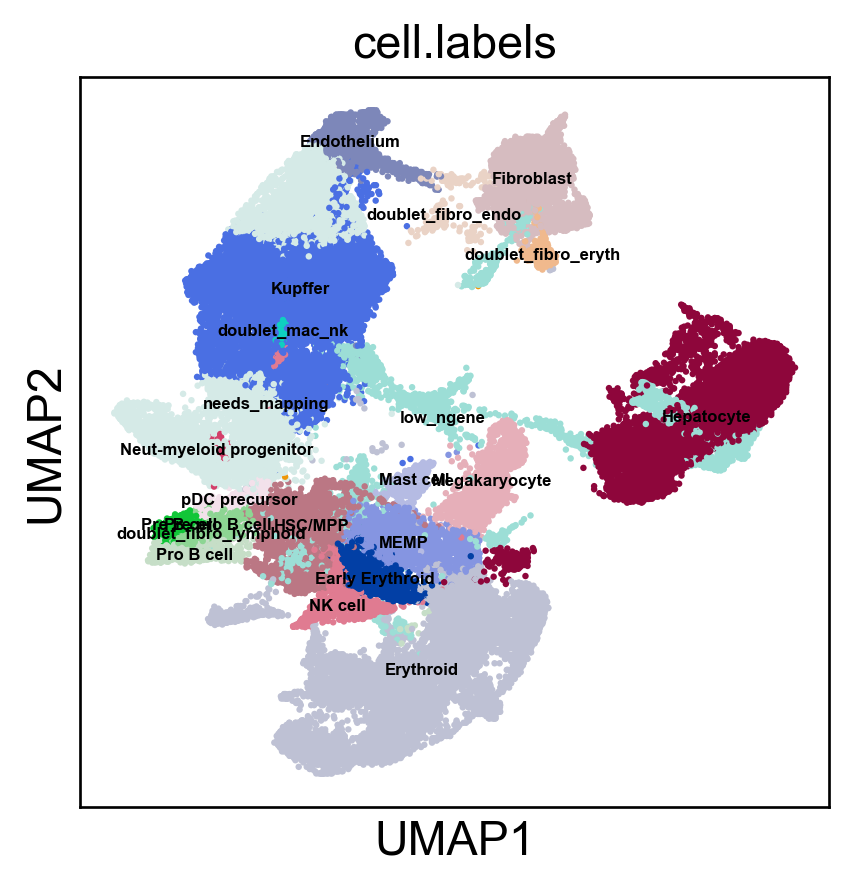

In [30]:
sc.pl.umap(adata, color='cell.labels', size=15, legend_loc="on data", legend_fontsize=5) 

# Remove the big groups of doublets highlighted in new annotation

In [31]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
Early Erythroid              1559
Endothelium                  1156
Erythroid                    9332
Fibroblast                   3356
HSC/MPP                      3332
Hepatocyte                   8197
Kupffer                     11349
MEMP                         1768
Mast cell                     465
Megakaryocyte                1439
NK cell                       832
Neut-myeloid progenitor        59
Pre B cell                    231
Pre pro B cell                511
Pro B cell                    461
doublet_fibro_endo            188
doublet_fibro_eryth           186
doublet_fibro_lymphoid         22
doublet_mac_nk                 40
low_ngene                    3039
needs_mapping                6611
pDC precursor                 198
dtype: int64

In [32]:
adata = adata[~adata.obs['cell.labels'].isin(['doublet_fibro_endo', 'doublet_fibro_eryth', 'low_ngene', 
         'doublet_fibro_lymphoid', 'doublet_mac_nk'])].copy()

In [33]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
Early Erythroid              1559
Endothelium                  1156
Erythroid                    9332
Fibroblast                   3356
HSC/MPP                      3332
Hepatocyte                   8197
Kupffer                     11349
MEMP                         1768
Mast cell                     465
Megakaryocyte                1439
NK cell                       832
Neut-myeloid progenitor        59
Pre B cell                    231
Pre pro B cell                511
Pro B cell                    461
needs_mapping                6611
pDC precursor                 198
dtype: int64

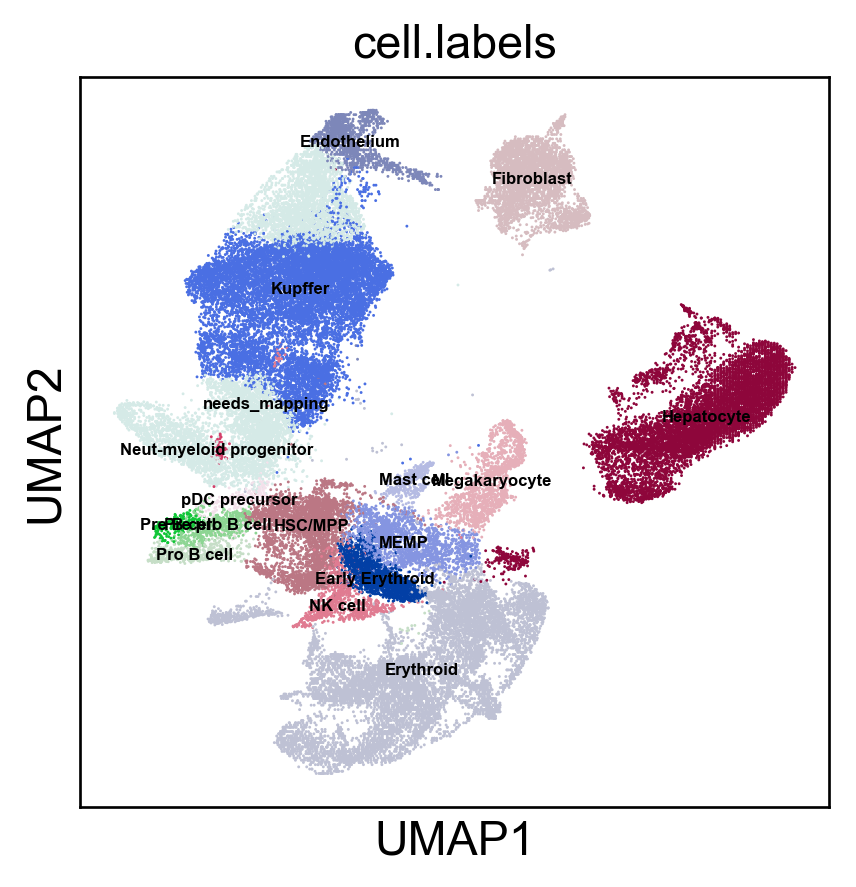

In [34]:
sc.pl.umap(adata, color='cell.labels', size=3, legend_loc="on data", legend_fontsize=5) 

In [35]:
adata.shape

(50856, 25756)

# Map all final annots across into one label

## Load in the Kupffer and endo annotations in from the Myeloid,1 subset annot csv (save as adata.obs["kup_endo"])

In [36]:
kup_endo = pd.read_csv('/Users/b8058304/Documents/PhD_work/Coding/ys/resources_for_pipelines/myeloid_subset_annots_20200422.csv', index_col=0)

In [37]:
kup_endo = kup_endo.replace(["Myeloid,1-1", "Myeloid,1-2", "Myeloid,1-3", "Myeloid,1-4"], ["Kupffer", "Endothelium", "Kupffer", "Endothelium"])

In [38]:
kup_endo = kup_endo.rename(columns={"subcluster_annotation": "annotated_clusters_reduced"})

In [39]:
cell_numbers = kup_endo.groupby(["annotated_clusters_reduced"]).apply(len)
cell_numbers

annotated_clusters_reduced
Endothelium    1252
Kupffer        1481
dtype: int64

## Load in the DC1/2 annotations from adata.obs["annot_clus_reduced"] > Myeloid,5 in subcluster_annotation (save as adata.obs["dc1_dc2"])

In [40]:
temp = adata[adata.obs['annotated_clusters_reduced'].isin(['DC1', 'DC2'])].copy()

In [41]:
dc1_dc2 = pd.DataFrame(temp.obs["annotated_clusters_reduced"])

In [42]:
cell_numbers = dc1_dc2.groupby(["annotated_clusters_reduced"]).apply(len)
cell_numbers

annotated_clusters_reduced
DC2    2186
DC1     217
dtype: int64

## Load in the mono/neut myeloid annotations from adata.obs["annot_clus_reduced"] > Myeloid,11 in subcluster_annotation (save as adata.obs["mono_neut"])

In [43]:
temp = adata[adata.obs['annotated_clusters_reduced'].isin(['Monocyte', 'Neut_Myeloid'])].copy()

In [44]:
mono_neut = pd.DataFrame(temp.obs["annotated_clusters_reduced"])

In [45]:
cell_numbers = mono_neut.groupby(["annotated_clusters_reduced"]).apply(len)
cell_numbers

annotated_clusters_reduced
Neut_Myeloid    622
Monocyte        912
dtype: int64

## Combine the three keys above

In [46]:
combined_df = pd.concat([kup_endo, dc1_dc2, mono_neut])

In [47]:
combined_df = combined_df.rename(columns={"annotated_clusters_reduced": "cell.labels"})

In [48]:
cell_numbers = combined_df.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
DC1              217
DC2             2186
Endothelium     1252
Kupffer         1481
Monocyte         912
Neut_Myeloid     622
dtype: int64

## Create a conditional - combine overall annots with the combined key for the three lists loaded above

In [49]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
Early Erythroid              1559
Endothelium                  1156
Erythroid                    9332
Fibroblast                   3356
HSC/MPP                      3332
Hepatocyte                   8197
Kupffer                     11349
MEMP                         1768
Mast cell                     465
Megakaryocyte                1439
NK cell                       832
Neut-myeloid progenitor        59
Pre B cell                    231
Pre pro B cell                511
Pro B cell                    461
needs_mapping                6611
pDC precursor                 198
dtype: int64

In [50]:
overall = pd.DataFrame(adata.obs["cell.labels"])
overall[:5]

,cell.labels
index,
F61_Liver_CD45+_FCAImmP7862084_AAACCTGAGACCGGAT,Early Erythroid
F61_Liver_CD45+_FCAImmP7862084_AAACCTGAGCTACCGC,Kupffer
F61_Liver_CD45+_FCAImmP7862084_AAACCTGAGTCCGGTC,Kupffer
F61_Liver_CD45+_FCAImmP7862084_AAACCTGAGTGTCCAT,needs_mapping
F61_Liver_CD45+_FCAImmP7862084_AAACCTGCAAGTAATG,Hepatocyte


In [51]:
overall.update(combined_df)

In [52]:
cell_numbers = overall.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
DC1                  217
DC2                 2186
Early Erythroid     1559
Endothelium         2408
Erythroid           9332
Fibroblast          3356
HSC/MPP             3332
Hepatocyte          8197
Kupffer            12830
MEMP                1768
Mast cell            465
Megakaryocyte       1439
Monocyte             912
NK cell              832
Neut_Myeloid         622
Pre B cell           231
Pre pro B cell       511
Pro B cell           461
pDC precursor        198
dtype: int64

In [53]:
overall[:5]

,cell.labels
index,
F61_Liver_CD45+_FCAImmP7862084_AAACCTGAGACCGGAT,Early Erythroid
F61_Liver_CD45+_FCAImmP7862084_AAACCTGAGCTACCGC,Kupffer
F61_Liver_CD45+_FCAImmP7862084_AAACCTGAGTCCGGTC,Kupffer
F61_Liver_CD45+_FCAImmP7862084_AAACCTGAGTGTCCAT,Kupffer
F61_Liver_CD45+_FCAImmP7862084_AAACCTGCAAGTAATG,Hepatocyte


In [54]:
adata.obs["cell.labels"] = overall

# Have a look at final annotations

In [55]:
cell_numbers = adata.obs.groupby(["cell.labels"]).apply(len)
cell_numbers

cell.labels
DC1                  217
DC2                 2186
Early Erythroid     1559
Endothelium         2408
Erythroid           9332
Fibroblast          3356
HSC/MPP             3332
Hepatocyte          8197
Kupffer            12830
MEMP                1768
Mast cell            465
Megakaryocyte       1439
Monocyte             912
NK cell              832
Neut_Myeloid         622
Pre B cell           231
Pre pro B cell       511
Pro B cell           461
pDC precursor        198
dtype: int64

In [56]:
adata.shape

(50856, 25756)

... storing 'cell.labels' as categorical


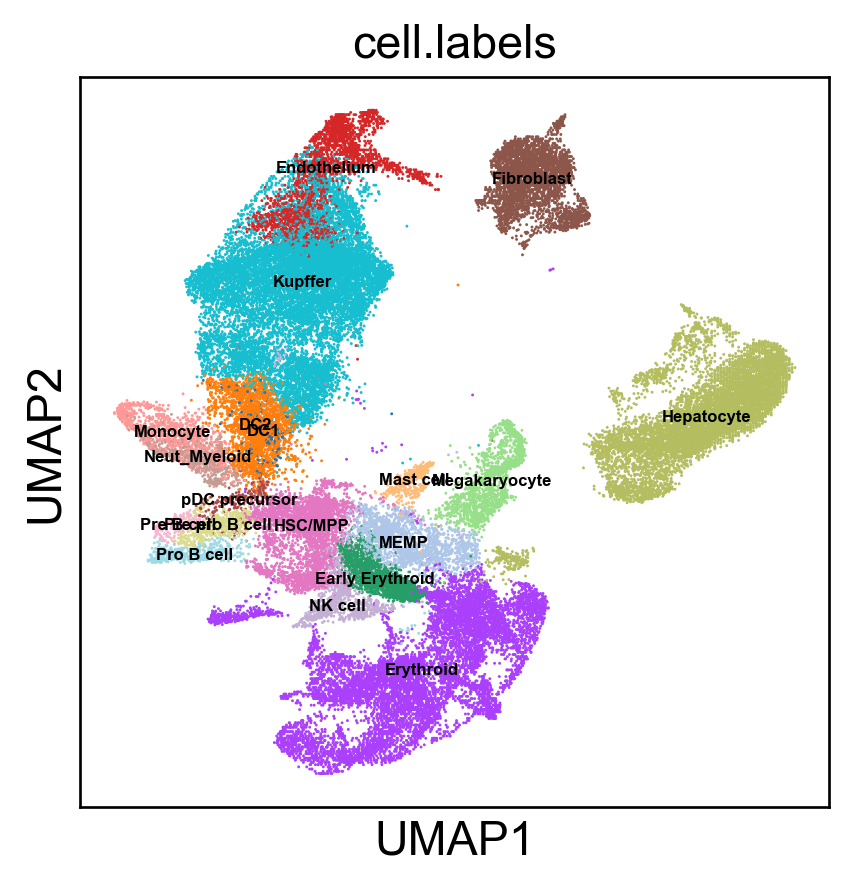

In [57]:
sc.pl.umap(adata, color='cell.labels', size=3, legend_loc="on data", legend_fontsize=5) 

# Save the raw, singlet, reannotated data

In [58]:
adata.write('/Users/b8058304/Documents/PhD_work/Coding/ys/data/Liver_data_YS_paper_singlets_raw_20200429.h5ad')